## Table of Contents
* [Dependencies](#Dependnecies)
* [Face Cropping](#faceCropping)
    * [Face Cropping Examples](#cropExamples)
* [Enhance Faces](#enhanceFaces)
    * [Enhance Examples](#enhanceExamples)
* [Align Faces](#alignFaces)
    * [Align Examples](#alignExamples)
* [Face Aging](#faceAging)
    * [Face Aging Examples](#faceAgeExamples)
* [Pipeline Run](#pipelineRun)
    * [Pipeline Run Examples](#pipelineExamples)

## Dependencies <a class="anchor" id="Dependnecies"></a>

In order to run the code, you need to clone into your root director:
- https://github.com/eladrich/pixel2style2pixel
- https://github.com/AbuAbdULLAH-MuhammadAli/FaceAgingStyleGANs

From https://github.com/davisking/dlib-models download the models (you may have to change the paths in the code):
- mmod_human_face_detector.dat (use to detect face)
- shape_predictor_68_face_landmarks.dat (use to detect face)

From https://drive.google.com/file/d/1pJ_T-V1dpb1ewoEra1TGSWl5e6H7M4NN/view download:
- RRDB_ESnRGAN_x4.pth  (use to enhance image)

In [2]:
import os
os.chdir('pixel2style2pixel')

In [3]:
from argparse import Namespace
import time
import sys
import pprint
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms
import dlib

sys.path.append(".")
sys.path.append("..")

# from datasets import augmentations
from utils.common import tensor2im, log_input_image
from pixel2style2pixel.models.psp import pSp

#%load_ext autoreload
#%autoreload 2

import cv2
import matplotlib.pyplot as plt 
import dlib
import os.path as osp
import glob
import numpy as np
import Enhancement.RRDBNet_arch as arch
from IPython import display
from tqdm import tqdm
import matplotlib

## 1. Crop Faces with Bounding Box <a class="anchor" id="faceCropping"></a>


In [19]:
%matplotlib inline
face_detector_path = cnn_model_path = '../dlib_model/mmod_human_face_detector.dat' #change for your path
cnn_face_detector = dlib.cnn_face_detection_model_v1(face_detector_path)

def detect_crop_face(img, display=False):
    image = cv2.imread(img)
    output_image = image.copy()
    imgRGB = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    results = cnn_face_detector(imgRGB,upsample_num_times =2)
    
    for bbox in results:
        x1 = bbox.rect.left()
        y1 = bbox.rect.top()
        x2 = bbox.rect.right()
        y2 = bbox.rect.bottom()
        w = x2-x1
        h = y2-y1
        
        x_adj = int(0.5*w )
        y_adj = int(0.5*h)
        x1_adj = x1-x_adj
        y1_adj = y1-y_adj
        x2_adj = x2+x_adj
        y2_adj = y2+y_adj
        points_adjust =[x1_adj,y1_adj,x2_adj,y2_adj]
        
        if x1_adj < 0:
            x1_adj = 0
        if y1_adj < 0:
            y1_adj = 0
        
        cv2.rectangle(output_image, pt1=(x1_adj,y1_adj), pt2=(x2_adj,y2_adj), color=(0, 0, 255), thickness=2)  
        output_image = output_image[y1_adj:y2_adj,x1_adj:x2_adj]
    if display:
        plt.imshow(cv2.cvtColor(output_image,cv2.COLOR_BGR2RGB))
        plt.show()
    path = f'atfalmafkoda_unzip/test_crop/face_crop{img}'
    #cv2.imwrite(path,output)
    return output_image

### Example Crops <a class="anchor" id="cropExamples"></a>

Cropped


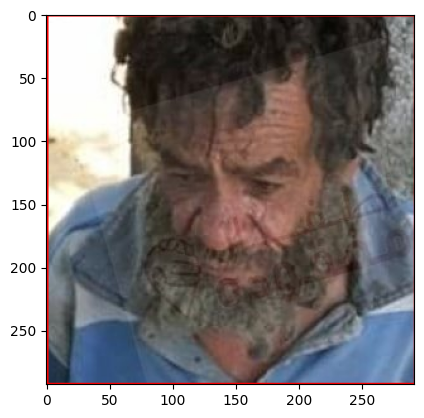

Initial


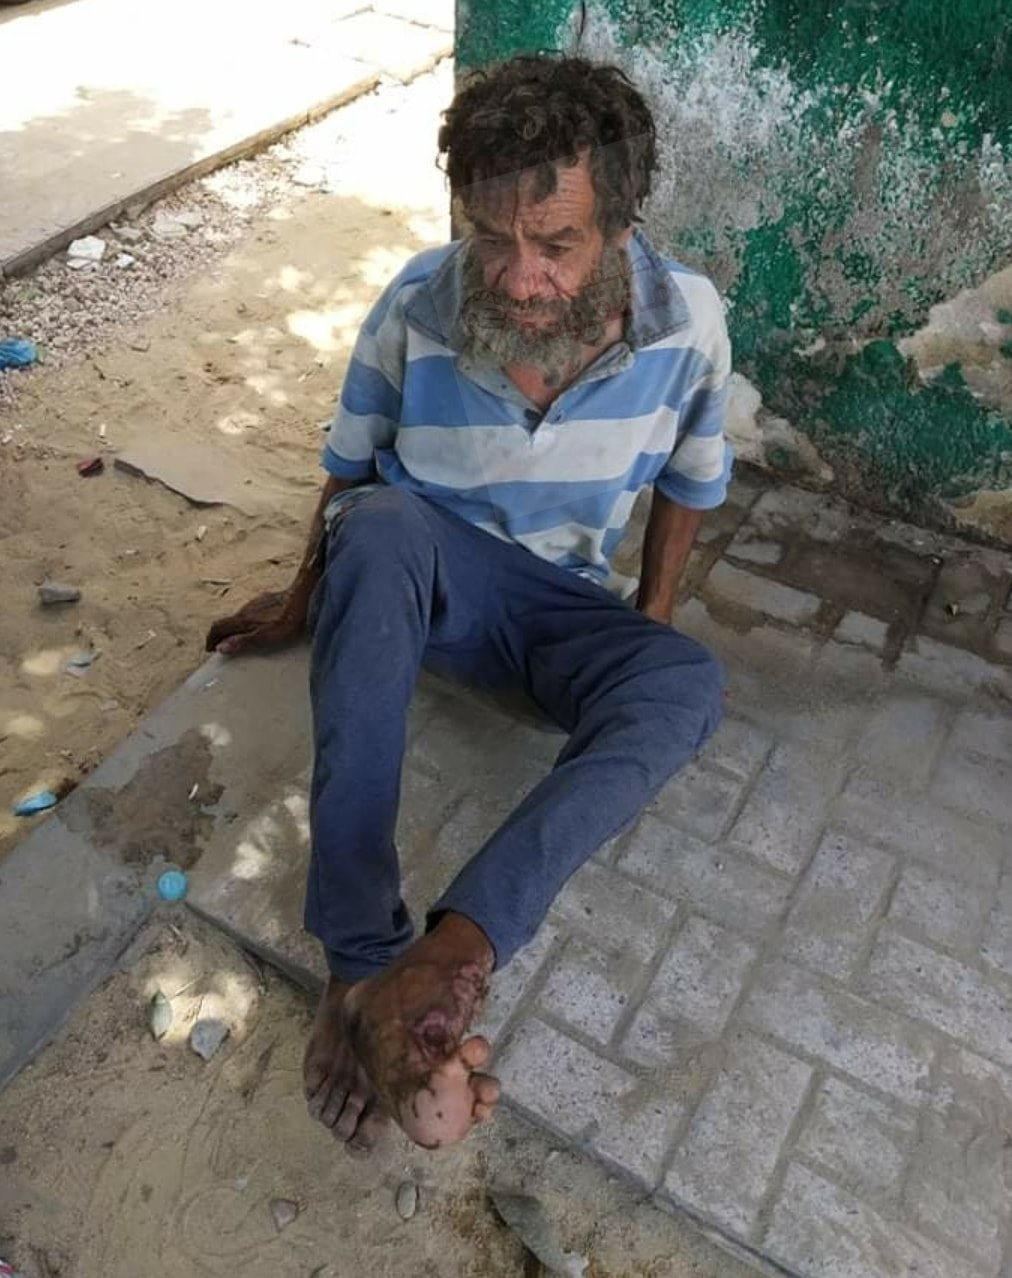

In [26]:
#change to path of image
path = '/projectnb/sparkgrp/ml-atfal-mafkoda-grp/atfalmafkoda_unzip/test_images/test_male/104195467_2458798551084424_6927236006699543654_n_2458798547751091.jpg'

print('Cropped')
detect_crop_face(path,display =True)
print('Initial')
display.Image(path,width=300,height=300)

Cropped


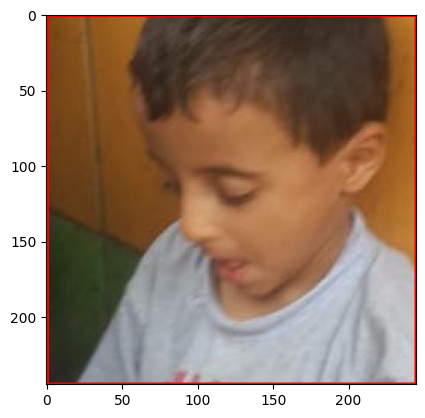

Initial


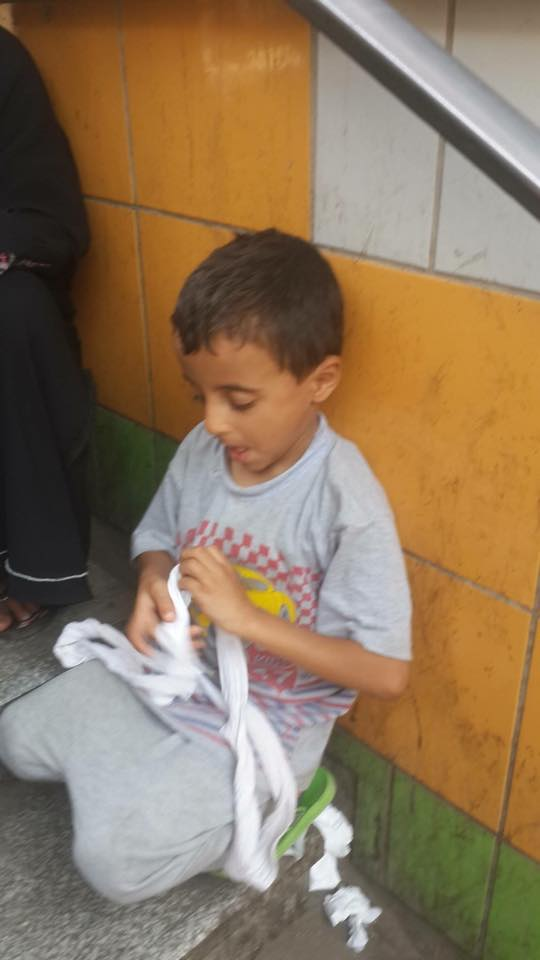

In [27]:
path = '/projectnb/sparkgrp/ml-atfal-mafkoda-grp/atfalmafkoda_unzip/test_images/test_male/11403233_1470869266544029_524822111022616096_n_1470869266544029.jpg'

print('Cropped')
detect_crop_face(path,display =True)
print('Initial')
display.Image(path,width=300,height=300)

Cropped


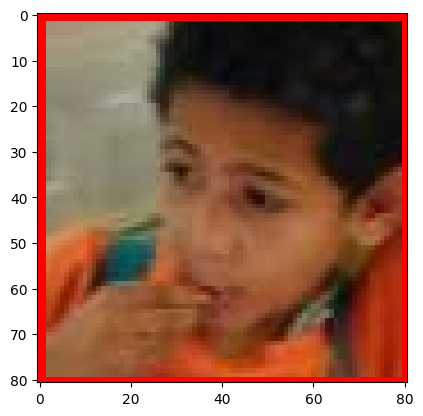

Initial


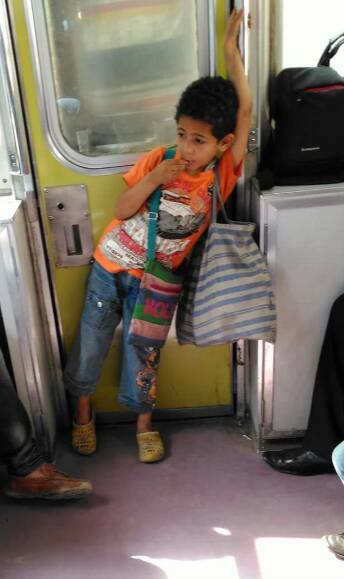

In [28]:
path = '/projectnb/sparkgrp/ml-atfal-mafkoda-grp/atfalmafkoda_unzip/test_images/test_male/13061939_1568283020135986_3881782395772516177_n_1568283020135986.jpg'

print('Cropped')
detect_crop_face(path,display =True)
print('Initial')
display.Image(path,width=300,height=300)

Cropped


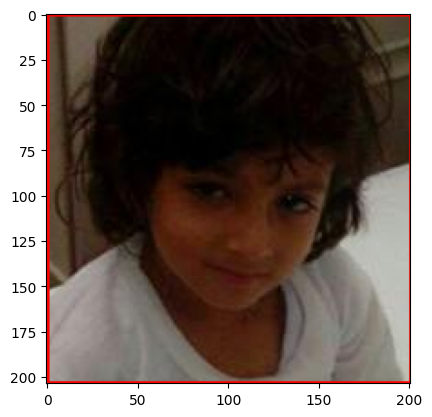

Initial


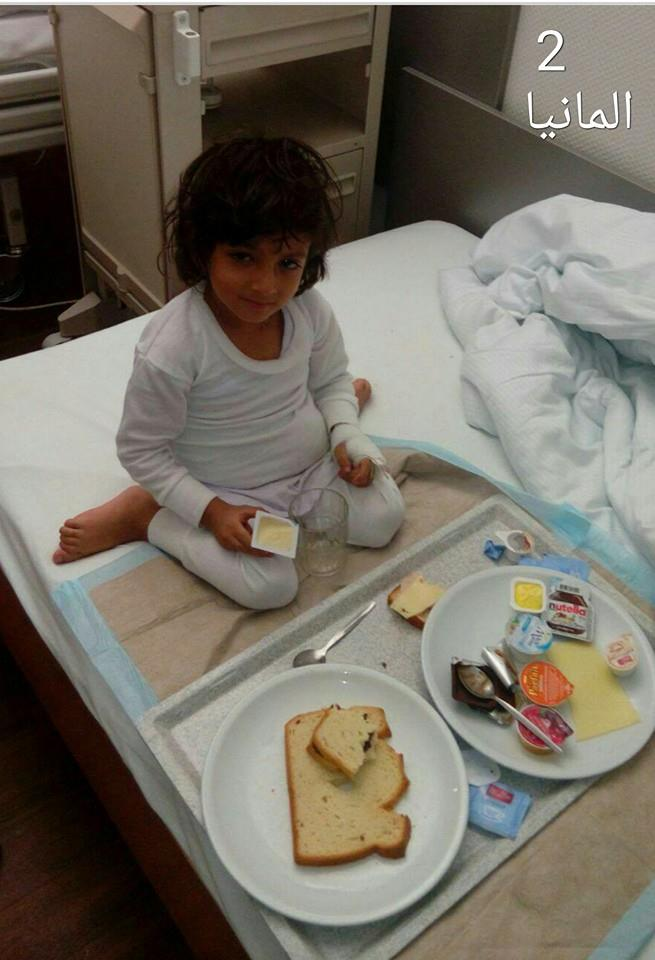

In [31]:
path = '/projectnb/sparkgrp/ml-atfal-mafkoda-grp/atfalmafkoda_unzip/test_images/test_female/12688113_1539916236305998_5462908077591201884_n_1539916236305998.jpg'

print('Cropped')
detect_crop_face(path,display =True)
print('Initial')
display.Image(path,width=300,height=300)

Cropped


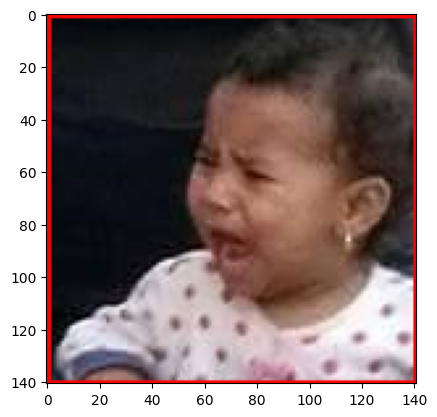

Initial


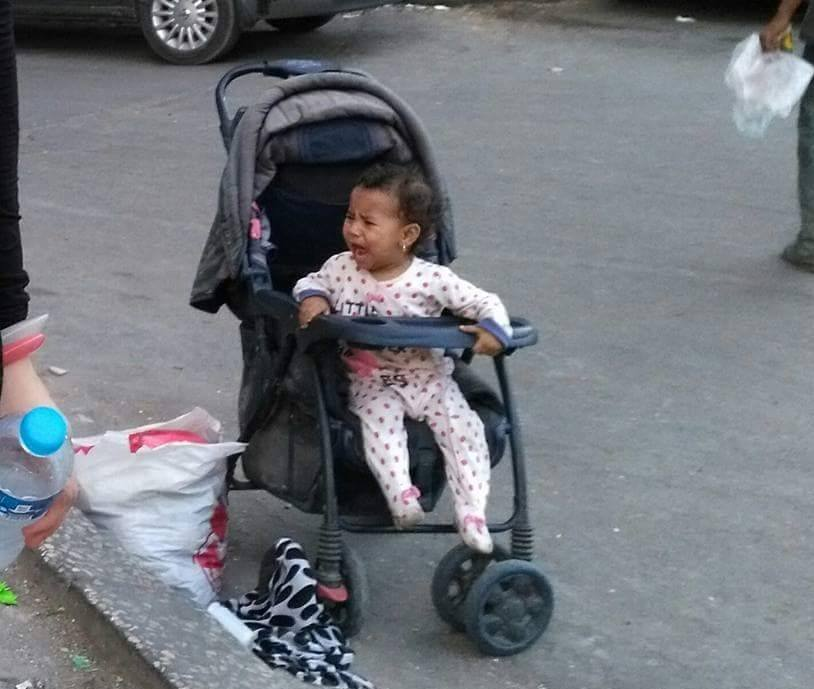

In [32]:
path = '/projectnb/sparkgrp/ml-atfal-mafkoda-grp/atfalmafkoda_unzip/test_images/test_female/14238336_1621990754765212_3253593621491271009_n_1621990754765212.jpg'

print('Cropped')
detect_crop_face(path,display =True)
print('Initial')
display.Image(path,width=300,height=300)

## 2. Enhance Faces<a class="anchor" id="enhanceFaces"></a>

In [14]:
def enhance_face(img):
    model_path = '../Enhancement/models/RRDB_ESnRGAN_x4.pth' # load the model
    device = torch.device('cuda')  # if you want to run on CPU, change 'cuda' -> cpu
    # device = torch.device('cpu')

    model = arch.RRDBNet(3, 3, 64, 23, gc=32)
    model.load_state_dict(torch.load(model_path), strict=True)
    model.eval()
    model = model.to(device)

#     for path in glob.glob(test_img_folder):
#     base = osp.splitext(osp.basename(img_path))[0]
    # read images
#     img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    output = None
    img = img * 1.0 / 255
    img = torch.from_numpy(np.transpose(img[:, :, [2, 1, 0]], (2, 0, 1))).float()
    img_LR = img.unsqueeze(0)
    img_LR = img_LR.to(device)

    with torch.no_grad():
        output = model(img_LR).data.squeeze().float().cpu().clamp_(0, 1).numpy()
    output = np.transpose(output[[2, 1, 0], :, :], (1, 2, 0))
    output = (output * 255.0).round()
#     cv2.imwrite('Enhancement/results/{:s}_rlt.png'.format(base), output)
    return output

### Example Enhance <a class="anchor" id="enhanceExamples"></a>

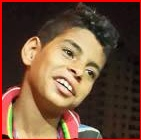

In [15]:
folder_path = '/projectnb/sparkgrp/ml-atfal-mafkoda-grp/atfalmafkoda_unzip/test_crop'
img_path = 'face_crop0.jpg'
path = folder_path + "/" + img_path
display.Image(path)

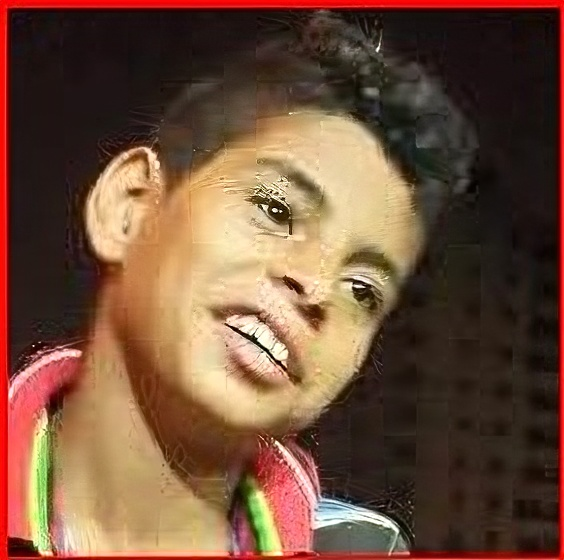

In [21]:
img = cv2.imread(path, cv2.IMREAD_COLOR)
output = enhance_face(img)
output = output.astype(np.uint8)
folder_path = '/projectnb/sparkgrp/ml-atfal-mafkoda-grp/atfalmafkoda_unzip/test_images_to_png'
output_path = folder_path + "/" + img_path
cv2.imwrite(output_path, output)
display.Image(output_path, height=150, width=150)

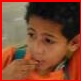

In [22]:
folder_path = '/projectnb/sparkgrp/ml-atfal-mafkoda-grp/atfalmafkoda_unzip/test_crop'
img_path = 'face_crop1.jpg'
path = folder_path + "/" + img_path
display.Image(path)

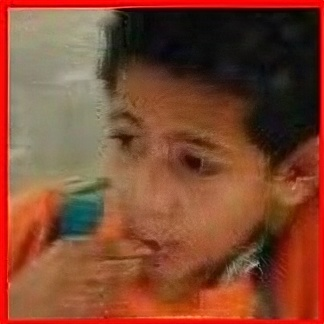

In [23]:
img = cv2.imread(path, cv2.IMREAD_COLOR)
output = enhance_face(img)
output = output.astype(np.uint8)
folder_path = '/projectnb/sparkgrp/ml-atfal-mafkoda-grp/atfalmafkoda_unzip/test_images_to_png'
output_path = folder_path + "/" + img_path
cv2.imwrite(output_path, output)
display.Image(output_path, height=150, width=150)

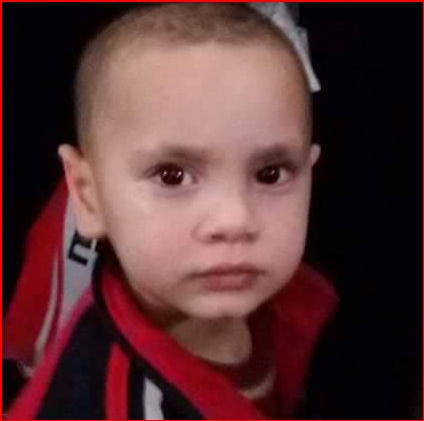

In [24]:
folder_path = '/projectnb/sparkgrp/ml-atfal-mafkoda-grp/atfalmafkoda_unzip/test_crop'
img_path = 'face_crop3.jpg'
path = folder_path + "/" + img_path
display.Image(path)

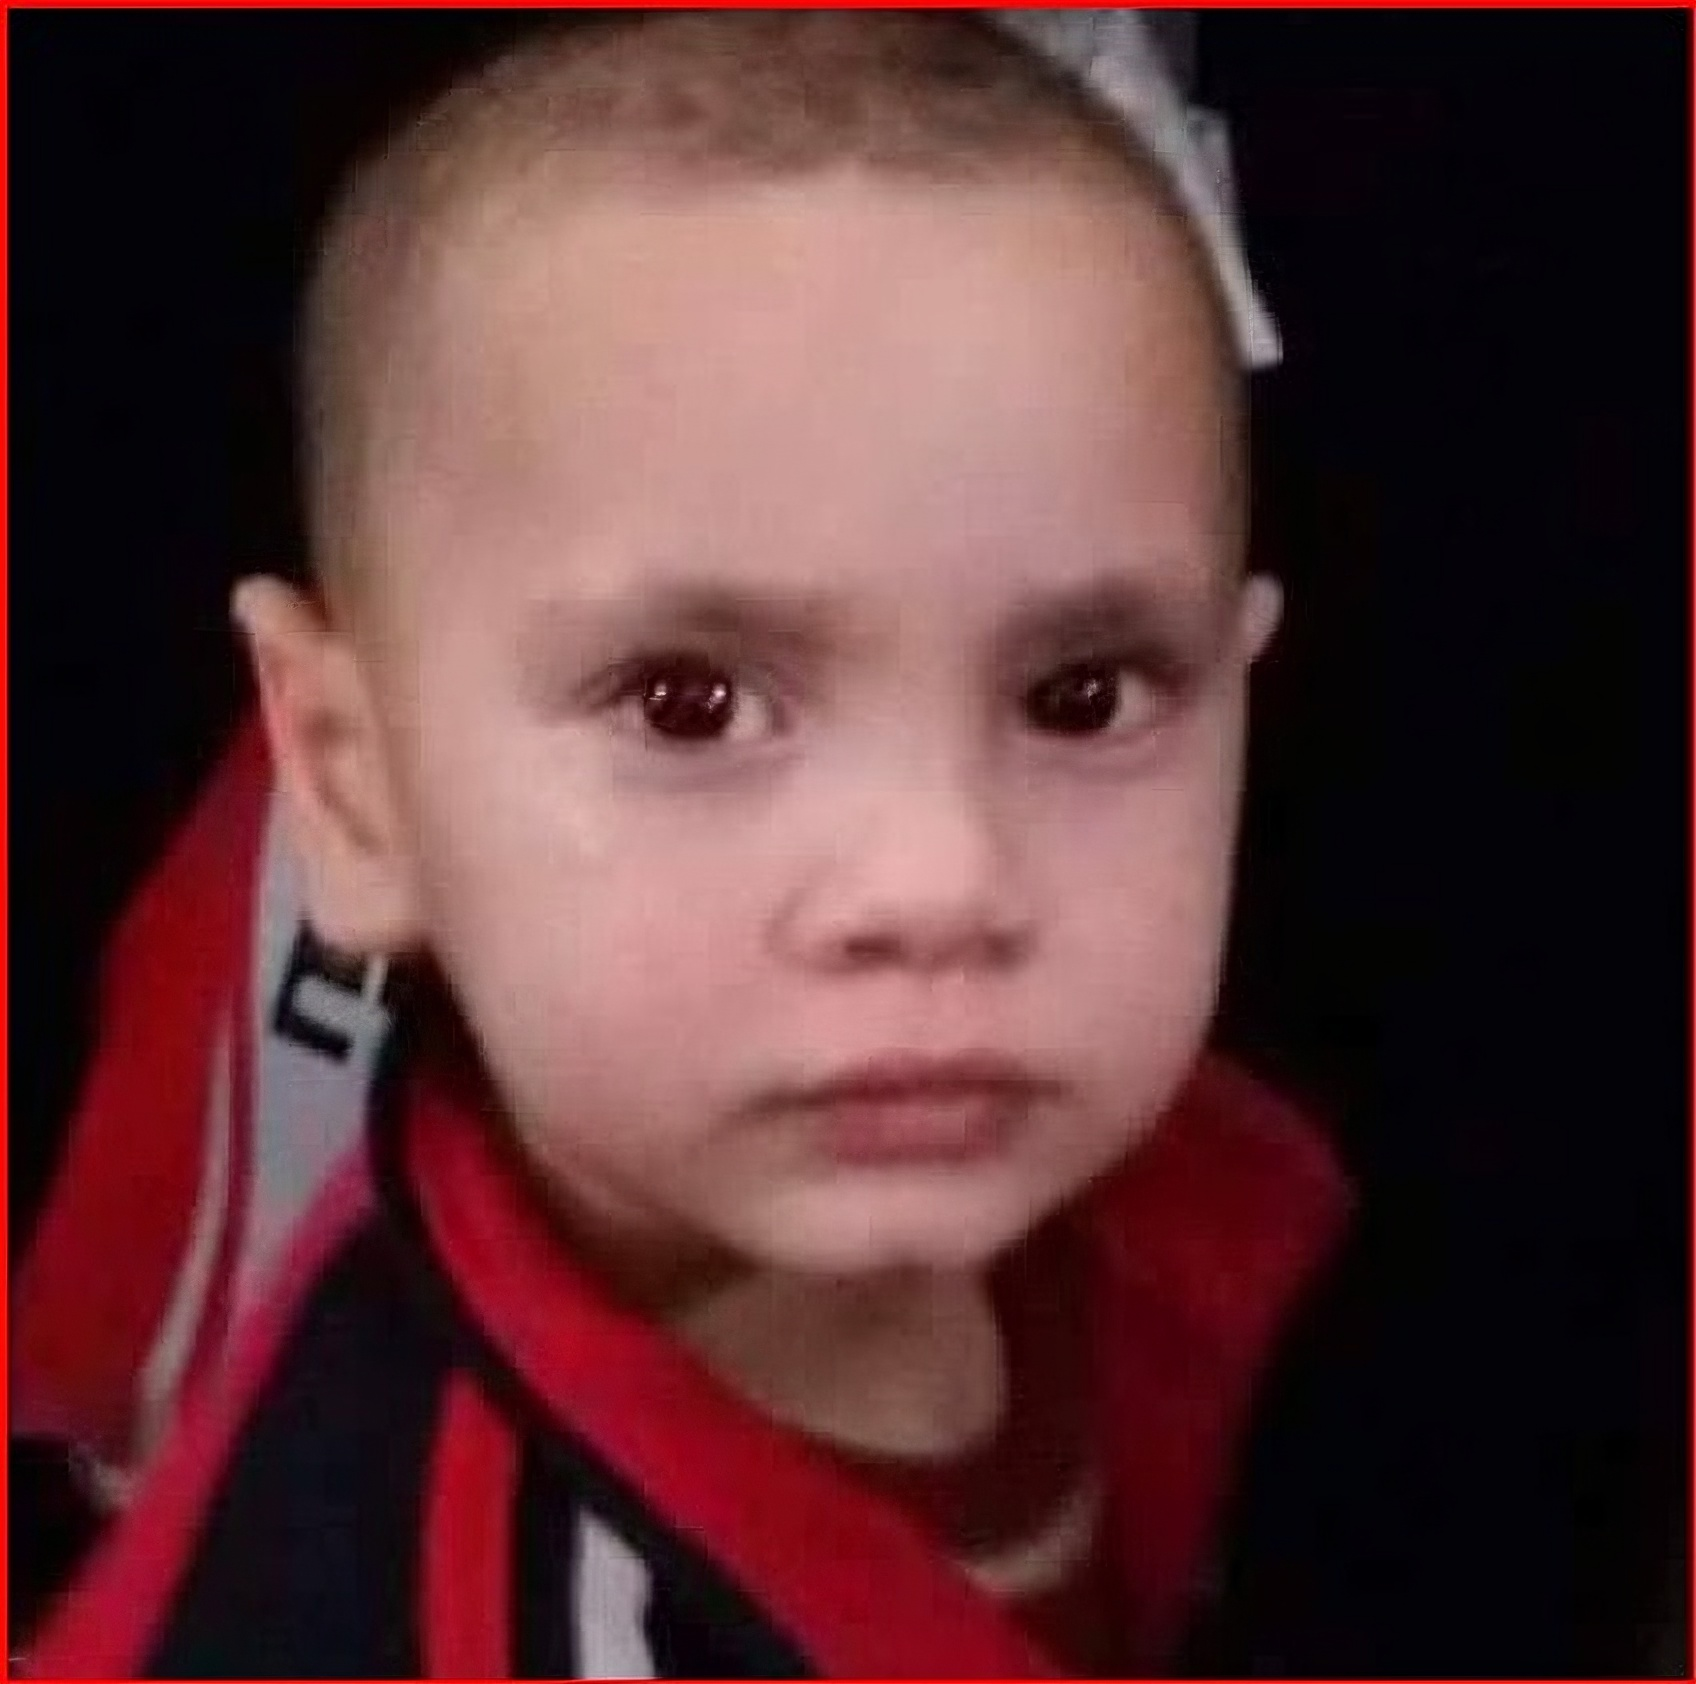

In [ ]:
img = cv2.imread(path, cv2.IMREAD_COLOR)
output = enhance_face(img)
output = output.astype(np.uint8)
folder_path = '/projectnb/sparkgrp/ml-atfal-mafkoda-grp/atfalmafkoda_unzip/test_images_to_png'
output_path = folder_path + "/" + img_path
cv2.imwrite(output_path, output)
display.Image(output_path, height=300, width=300)

## 3. Align Faces <a class="anchor" id="alignFaces"></a>

In [4]:
experiment_type = 'ffhq_frontalize' 

In [1]:
#if running for the first time, uncomment the following code and download the model

# CODE_DIR = 'pixel2style2pixel'
# def get_download_model_command(file_id, file_name):
#     """ Get wget download command for downloading the desired model and save to directory ../pretrained_models. """
#     current_directory = os.getcwd()
#     save_path = os.path.join(os.path.dirname(current_directory), CODE_DIR, "pretrained_models")
#     if not os.path.exists(save_path):
#         os.makedirs(save_path)
#     url = r"""wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={FILE_ID}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={FILE_ID}" -O {SAVE_PATH}/{FILE_NAME} && rm -rf /tmp/cookies.txt""".format(FILE_ID=file_id, FILE_NAME=file_name, SAVE_PATH=save_path)
#     return url

# MODEL_PATHS = {
#     "ffhq_encode": {"id": "1bMTNWkh5LArlaWSc_wa8VKyq2V42T2z0", "name": "psp_ffhq_encode.pt"},
#     "ffhq_frontalize": {"id": "1_S4THAzXb-97DbpXmanjHtXRyKxqjARv", "name": "psp_ffhq_frontalization.pt"},
#     "celebs_super_resolution": {"id": "1ZpmSXBpJ9pFEov6-jjQstAlfYbkebECu", "name": "psp_celebs_super_resolution.pt"},
# }

# path = MODEL_PATHS[experiment_type]
# download_command = get_download_model_command(file_id=path["id"], file_name=path["name"])
# !{download_command}

In [6]:
EXPERIMENT_DATA_ARGS = {
    "ffhq_frontalize": {
        "model_path": "pretrained_models/psp_ffhq_frontalization.pt",
        "image_path": "notebooks/images/input_img.jpg",
        "transform": transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    },
    "celebs_super_resolution": {
        "model_path": "pretrained_models/psp_celebs_super_resolution.pt",
        "image_path": "notebooks/images/input_img.jpg",
        "transform": transforms.Compose([
            transforms.Resize((256, 256)),
            augmentations.BilinearResize(factors=[16]),
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    }
}
EXPERIMENT_ARGS = EXPERIMENT_DATA_ARGS[experiment_type]

In [7]:
model_path = EXPERIMENT_ARGS['model_path']
ckpt = torch.load(model_path, map_location='cpu')

In [8]:
opts = ckpt['opts']
pprint.pprint(opts)

{'batch_size': 8,
 'board_interval': 50,
 'checkpoint_path': None,
 'dataset_type': 'ffhq_frontalize',
 'device': 'cuda:0',
 'encoder_type': 'GradualStyleEncoder',
 'exp_dir': '',
 'id_lambda': 1.0,
 'image_interval': 100,
 'input_nc': 3,
 'l2_lambda': 0.001,
 'l2_lambda_crop': 0.01,
 'label_nc': 0,
 'learning_rate': 0.0001,
 'lpips_lambda': 0.08,
 'lpips_lambda_crop': 0.8,
 'max_steps': 80000,
 'optim_name': 'ranger',
 'resize_factors': None,
 'save_interval': 5000,
 'start_from_latent_avg': True,
 'stylegan_weights': '',
 'test_batch_size': 8,
 'test_workers': 2,
 'train_decoder': False,
 'val_interval': 2500,
 'w_norm_lambda': 0.005,
 'workers': 8}


In [9]:
opts['checkpoint_path'] = model_path
if 'learn_in_w' not in opts:
    opts['learn_in_w'] = False
if 'output_size' not in opts:
    opts['output_size'] = 1024

In [10]:
opts = Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

Loading pSp from checkpoint: pretrained_models/psp_ffhq_frontalization.pt
Model successfully loaded!


In [16]:
#next two functions are helper functions defined by psp notebook
def run_alignment(image_path):
    from scripts.align_all_parallel import align_face
    predictor = dlib.shape_predictor("../shape_predictor_68_face_landmarks.dat")
    aligned_image = align_face(filepath=image_path, predictor=predictor)
    print("Aligned image has shape: {}".format(aligned_image.size))
    return aligned_image


def run_on_batch(inputs, net, latent_mask=None):
    if latent_mask is None:
        result_batch = net(inputs.to("cuda").float(), randomize_noise=False)
    else:
        result_batch = []
        for image_idx, input_image in enumerate(inputs):
            # get latent vector to inject into our input image
            vec_to_inject = np.random.randn(1, 512).astype('float32')
            _, latent_to_inject = net(torch.from_numpy(vec_to_inject).to("cuda"),
                                      input_code=True,
                                      return_latents=True)
            # get output image with injected style vector
            res = net(input_image.unsqueeze(0).to("cuda").float(),
                      latent_mask=latent_mask,
                      inject_latent=latent_to_inject)
            result_batch.append(res)
        result_batch = torch.cat(result_batch, dim=0)
    return result_batch

#packaging the aligning face into one function
def align_face(img, net):
    original_image = Image.open(img)
    original_image = original_image.convert("RGB")
    #original_image.resize((256, 256))
    
    input_image = run_alignment(img)
    #input_image.resize((256, 256))
    
    img_transforms = EXPERIMENT_ARGS['transform']
    transformed_image = img_transforms(input_image)
    
    latent_mask = None
    with torch.no_grad():
        tic = time.time()
        result_image = run_on_batch(transformed_image.unsqueeze(0), net, latent_mask)[0]
        toc = time.time()
        print('Inference took {:.4f} seconds.'.format(toc - tic))
    
    input_vis_image = log_input_image(transformed_image, opts)
    output_image = tensor2im(result_image)
    res = np.concatenate([np.array(input_vis_image.resize((256, 256))),
                          np.array(output_image.resize((256, 256)))], axis=1)
    res_image = Image.fromarray(res)
    return res_image
    

### Example Align <a class="anchor" id="alignExamples"></a>

Aligned image has shape: (256, 256)
Inference took 0.0245 seconds.


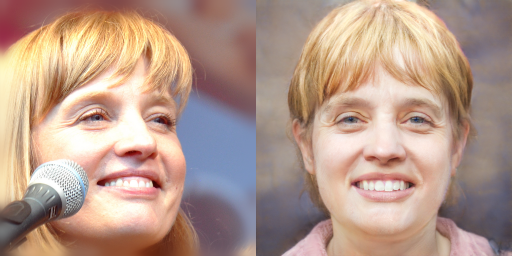

In [18]:
path = "../pipeline_test_data_ffhq/female56665.png"
i = align_face(path, net)
i

Aligned image has shape: (256, 256)
Inference took 0.0245 seconds.


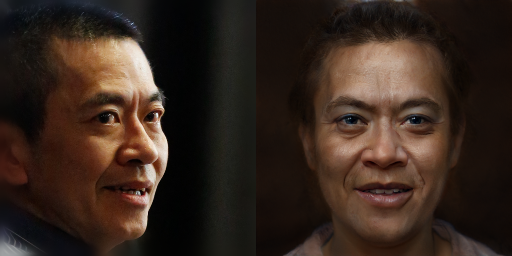

In [19]:
path = "../pipeline_test_data_ffhq/male34138.png"
i2 = align_face(path, net)
i2

Aligned image has shape: (256, 256)
Inference took 0.0246 seconds.


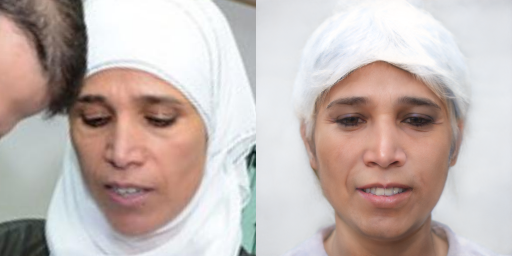

In [20]:
path = "../pipeline_test_data_ffhq/femaleff2377.jpg"
i3 = align_face(path, net)
i3

## 4. Pass through FaceAgingGAN<a class="anchor" id="faceAging"></a>

In [12]:
import os
os.chdir('../FaceAgingStyleGANs')

from collections import OrderedDict
from options.test_options import TestOptions
from data.data_loader import CreateDataLoader
from FaceAgingStyleGANs.models.models import create_model
import util.util as util
from util.visualizer import Visualizer

opt = TestOptions().parse(save=False)
opt.display_id = 0 # do not launch visdom
opt.nThreads = 1   # test code only supports nThreads = 1
opt.batchSize = 1  # test code only supports batchSize = 1
opt.serial_batches = True  # no shuffle
opt.no_flip = True  # no flip
opt.in_the_wild = True # This triggers preprocessing of in the wild images in the dataloader
opt.traverse = True # This tells the model to traverse the latent space between anchor classes
#opt.interp_step = 0.05 # this controls the number of images to interpolate between anchor classes

------------ Options -------------
activation: lrelu
batchSize: 1
checkpoints_dir: ./checkpoints
compare_to_trained_class: 1
compare_to_trained_outputs: False
conv_weight_norm: True
dataroot: ./datasets/males/
debug_mode: False
decoder_norm: pixel
deploy: False
display_id: 1
display_port: 8097
display_single_pane_ncols: 6
display_winsize: 256
fineSize: 256
full_progression: False
gen_dim_per_style: 50
gpu_ids: [0]
how_many: 50
id_enc_norm: pixel
image_path_file: None
in_the_wild: False
input_nc: 3
interp_step: 0.5
isTrain: False
loadSize: 256
make_video: False
max_dataset_size: inf
nThreads: 4
n_adaptive_blocks: 4
n_downsample: 2
name: debug
ngf: 64
no_cond_noise: False
no_flip: False
no_moving_avg: False
normalize_mlp: True
ntest: inf
output_nc: 3
phase: test
random_seed: -1
resize_or_crop: resize_and_crop
results_dir: ./results/
serial_batches: False
sort_classes: True
sort_order: ['0-2', '3-6', '7-9', '15-19', '30-39', '50-69']
trained_class_jump: 1
traverse: False
use_modulated_con

usage: ipykernel_launcher.py [-h] [--name NAME] [--gpu_ids GPU_IDS]
                             [--checkpoints_dir CHECKPOINTS_DIR]
                             [--batchSize BATCHSIZE] [--loadSize LOADSIZE]
                             [--fineSize FINESIZE] [--input_nc INPUT_NC]
                             [--output_nc OUTPUT_NC] [--dataroot DATAROOT]
                             [--sort_classes SORT_CLASSES]
                             [--sort_order SORT_ORDER]
                             [--resize_or_crop RESIZE_OR_CROP]
                             [--serial_batches] [--no_flip]
                             [--nThreads NTHREADS]
                             [--max_dataset_size MAX_DATASET_SIZE]
                             [--display_single_pane_ncols DISPLAY_SINGLE_PANE_NCOLS]
                             [--display_winsize DISPLAY_WINSIZE]
                             [--display_port DISPLAY_PORT]
                             [--display_id DISPLAY_ID]
                         

In [13]:
#!python download_models.py

In [14]:
#wrapper function for aging the face
def age_face(img, opt, gender, d):
    data_loader = CreateDataLoader(opt)
    dataset = data_loader.load_data()
    visualizer = Visualizer(opt)
    
    if gender == 'male':
        opt.name = 'males_model'
    else: 
        opt.name = 'females_model' 
    
    model = create_model(opt)
    model.eval()
    
    data = dataset.dataset.get_item_from_path(img)
    visuals = model.inference(data)
    
    os.makedirs('results', exist_ok=True)
    out_path = os.path.join('results', os.path.splitext(img.lstrip(d+"/"))[0].replace(' ', '_') + '.jpg')
    print(out_path)
    visualizer.save_row_image(visuals, out_path, traverse=True)

## Face Age Example <a class="anchor" id="faceAgeExamples"></a>

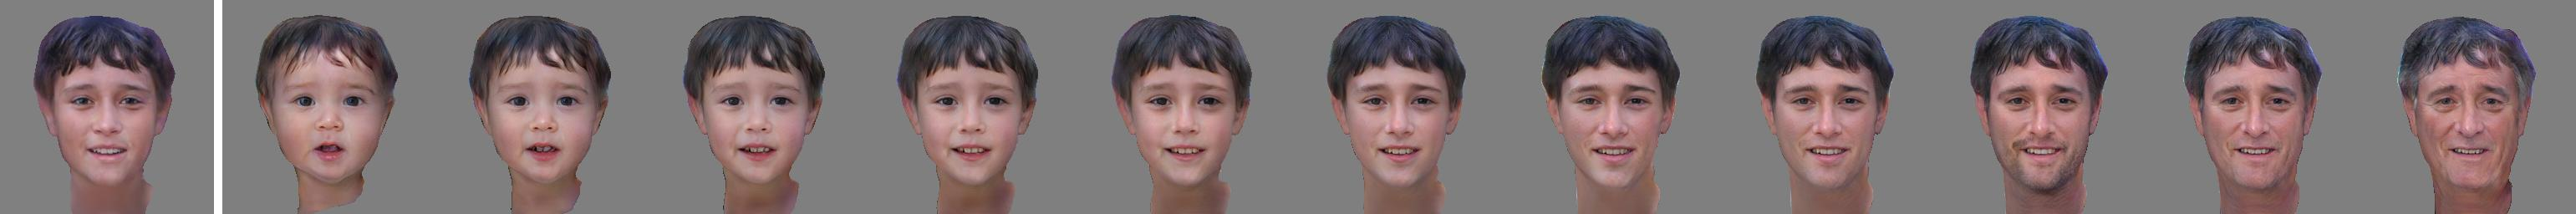

In [15]:
from IPython import display
display.Image("results/gn_test.jpg")

## Pipeline Run <a class="anchor" id="pipelineRun"></a>

In [16]:
import tempfile
from IPython import display
from PIL import Image

#alternatively
def inference(img, opt, gender, detect=True, enhance=True, align=True):
    if detect:
        img = detect_crop_face(img)
    if enhance:
        img = enhance_face(img)
    img = img.astype(np.uint8)
    with tempfile.TemporaryDirectory() as tmpdirname:
        print('created temporary directory', tmpdirname)
        if align:
            cv2.imwrite(tmpdirname+"/tempimg.jpg",img)
            img = align_face(tmpdirname+"/tempimg.jpg", net)
            img.save(tmpdirname+"/processedimg.jpg", "JPEG")
        else:
            cv2.imwrite(tmpdirname+"/processedimg.jpg",img)
    
        age_face(tmpdirname+"/processedimg.jpg", opt, gender, tmpdirname)

## Examples of Pipeline Run <a class="anchor" id="pipelineExamples"></a>

Args for inference
- img: image path
- opt: optimizer for face aging GAN (defined above, just pass in "opt")
- gender: target gender for face 
- detect: boolean T/F- set to True if you want to detect the face
- enhance: boolean T/F- set to True if you want to enhance the image (not recommended for good quality images)
- align: boolean T/F- set to True if the face is not frontalized (not recommended if face is already frontalized)

### 1. 

In [17]:
#torch.cuda.empty_cache()
path = "../atfalmafkoda_unzip/test_images/121374409_2565231617107783_7695266934953700188_n_2565231610441117.jpg"
inference(path, opt, 'male', enhance=False)

created temporary directory /scratch/6872595.1.csgpu/tmpb3dql4i_
Aligned image has shape: (256, 256)
Inference took 1.4882 seconds.
AgingDataLoader
dataset [MulticlassUnalignedDataset] was created
Generator(
  (id_encoder): IdentityEncoder(
    (encoder): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): EqualConv2d(
        (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
      )
      (2): PixelNorm()
      (3): ReLU(inplace=True)
      (4): ReflectionPad2d((1, 1, 1, 1))
      (5): EqualConv2d(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
      )
      (6): PixelNorm()
      (7): ReLU(inplace=True)
      (8): ReflectionPad2d((1, 1, 1, 1))
      (9): EqualConv2d(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
      )
      (10): PixelNorm()
      (11): ReLU(inplace=True)
      (12): ResnetBlock(
        (conv_block): Sequential(
          (0): ReflectionPad2d((1, 1, 1, 1))
          (1): EqualConv2d(
            (conv): 

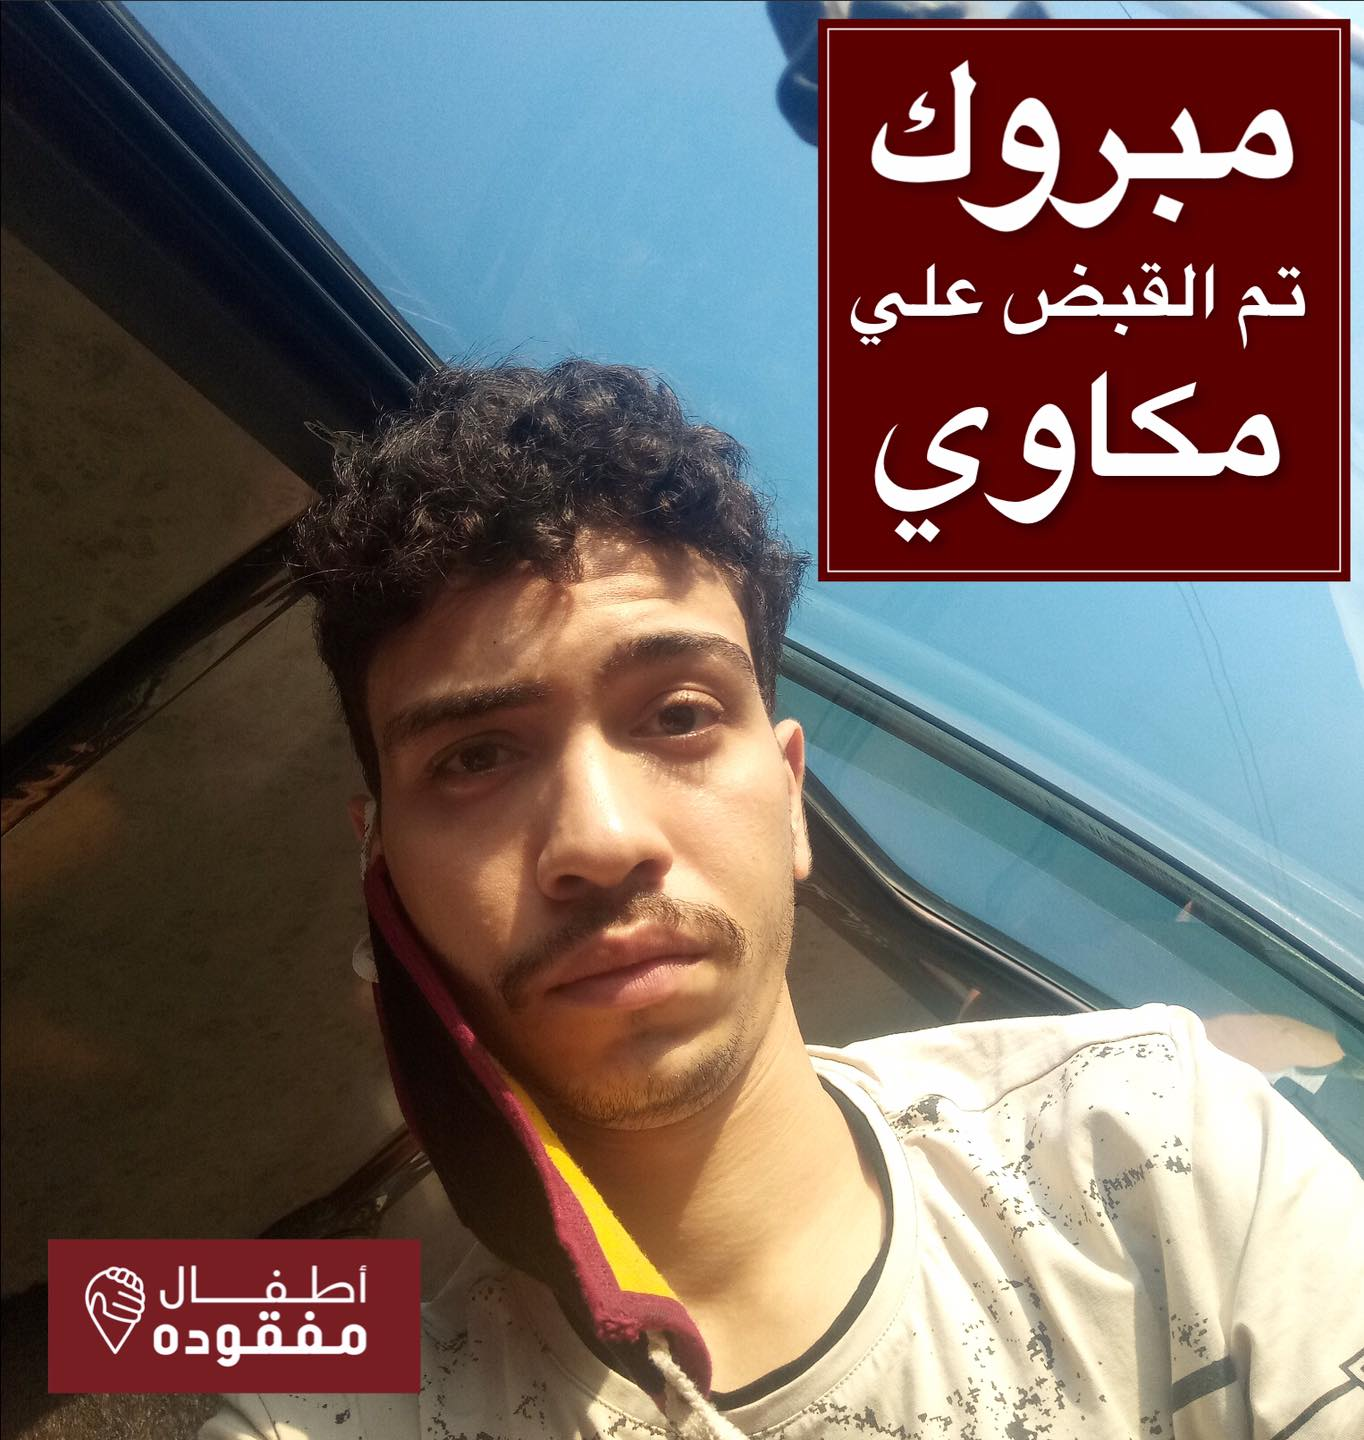

In [18]:
display.Image("../atfalmafkoda_unzip/test_images/121374409_2565231617107783_7695266934953700188_n_2565231610441117.jpg", width=300, height=300)

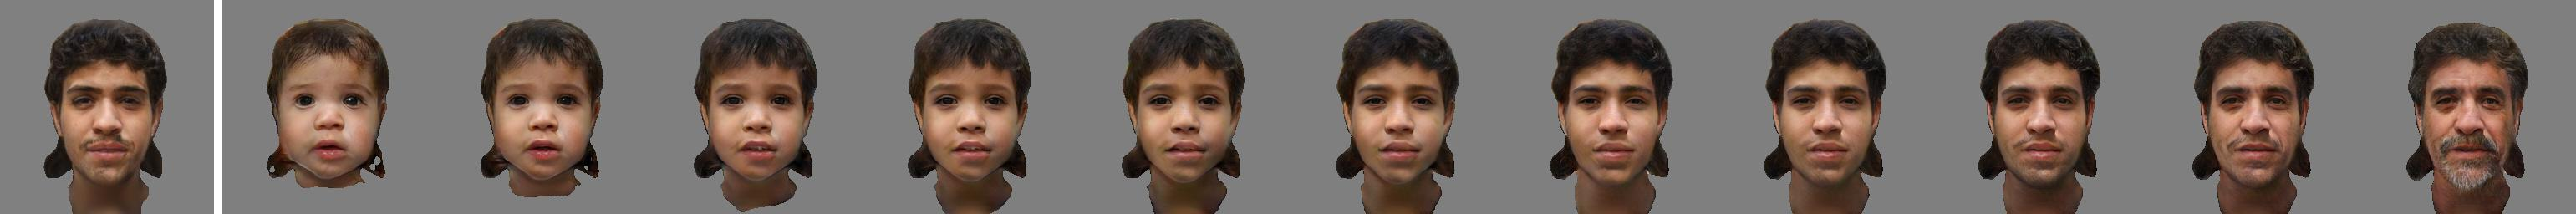

In [19]:
display.Image("results/ocessedimg.jpg")

### 2.

In [20]:
path = "../atfalmafkoda_unzip/test_images/90183687_2387240348240245_1805144414859821056_n_2387240344906912.jpg"
inference(path, opt, 'female', enhance=True, align=False)


created temporary directory /scratch/6872595.1.csgpu/tmp2l_nzgwo
AgingDataLoader
dataset [MulticlassUnalignedDataset] was created
Generator(
  (id_encoder): IdentityEncoder(
    (encoder): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): EqualConv2d(
        (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
      )
      (2): PixelNorm()
      (3): ReLU(inplace=True)
      (4): ReflectionPad2d((1, 1, 1, 1))
      (5): EqualConv2d(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
      )
      (6): PixelNorm()
      (7): ReLU(inplace=True)
      (8): ReflectionPad2d((1, 1, 1, 1))
      (9): EqualConv2d(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
      )
      (10): PixelNorm()
      (11): ReLU(inplace=True)
      (12): ResnetBlock(
        (conv_block): Sequential(
          (0): ReflectionPad2d((1, 1, 1, 1))
          (1): EqualConv2d(
            (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
          )
   

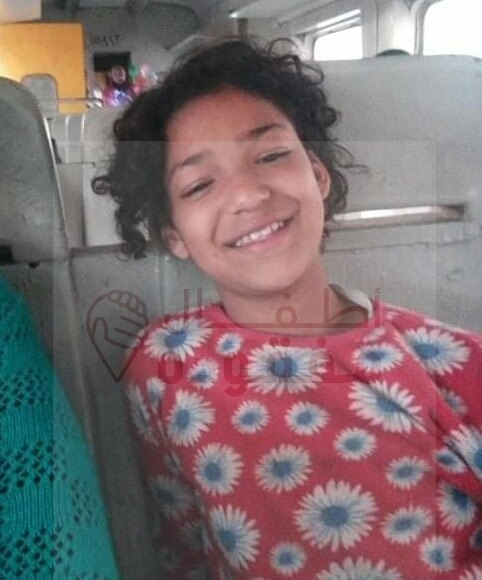

In [21]:
display.Image("../atfalmafkoda_unzip/test_images/90183687_2387240348240245_1805144414859821056_n_2387240344906912.jpg", width=300, height=300)

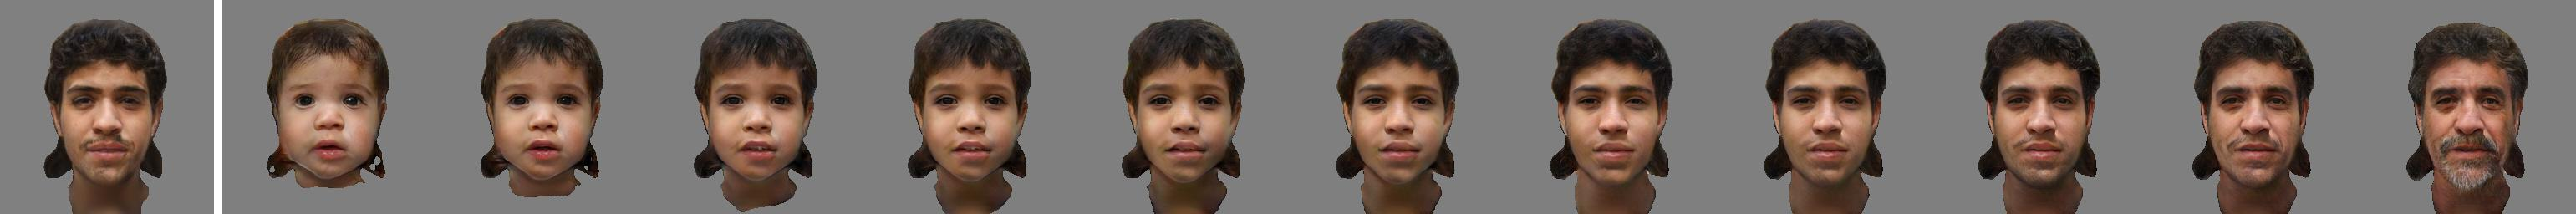

In [22]:
display.Image("results/ocessedimg.jpg")

### 3. 

In [23]:
path = "../atfalmafkoda_unzip/test_images/52678069_2078460615784888_4380224587258920960_n_2078460612451555.jpg"
inference(path, opt, 'female', enhance=True)

created temporary directory /scratch/6872595.1.csgpu/tmp0ojs3rp7
Aligned image has shape: (256, 256)
Inference took 0.0350 seconds.
AgingDataLoader
dataset [MulticlassUnalignedDataset] was created
Generator(
  (id_encoder): IdentityEncoder(
    (encoder): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): EqualConv2d(
        (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
      )
      (2): PixelNorm()
      (3): ReLU(inplace=True)
      (4): ReflectionPad2d((1, 1, 1, 1))
      (5): EqualConv2d(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
      )
      (6): PixelNorm()
      (7): ReLU(inplace=True)
      (8): ReflectionPad2d((1, 1, 1, 1))
      (9): EqualConv2d(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
      )
      (10): PixelNorm()
      (11): ReLU(inplace=True)
      (12): ResnetBlock(
        (conv_block): Sequential(
          (0): ReflectionPad2d((1, 1, 1, 1))
          (1): EqualConv2d(
            (conv): 

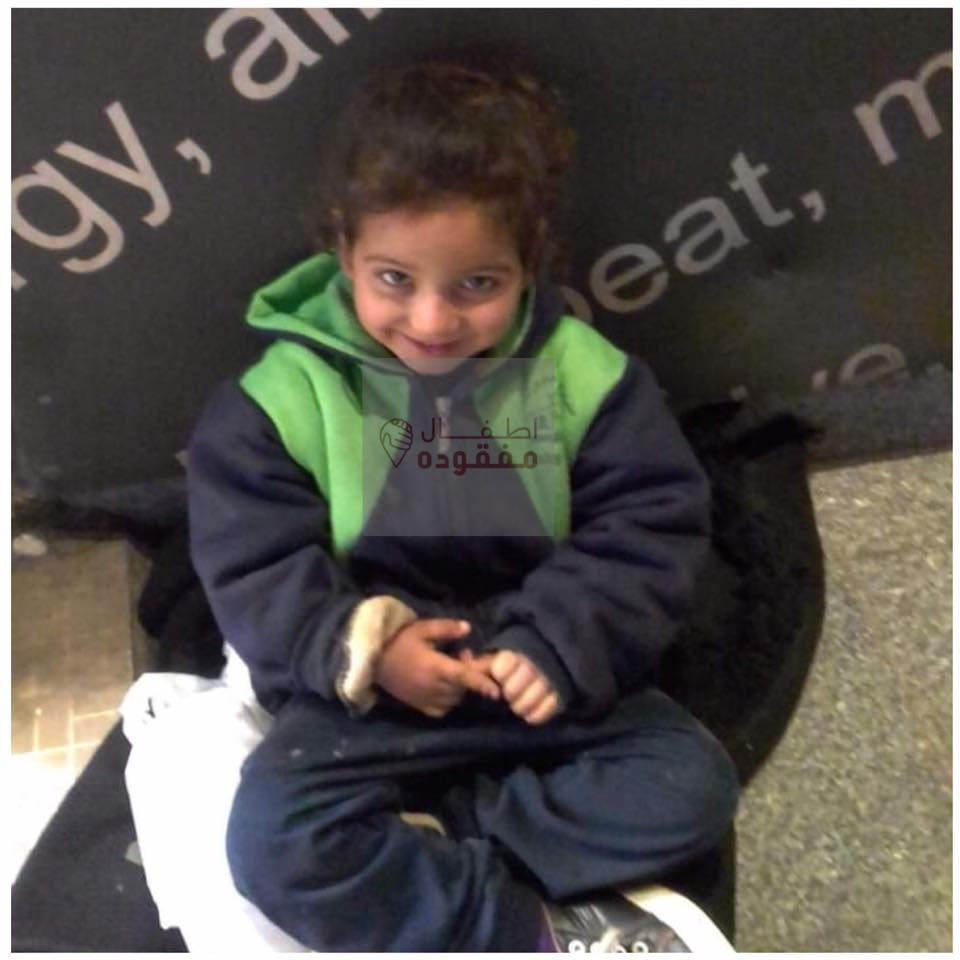

In [24]:
display.Image("../atfalmafkoda_unzip/test_images/52678069_2078460615784888_4380224587258920960_n_2078460612451555.jpg", width=300, height=300)

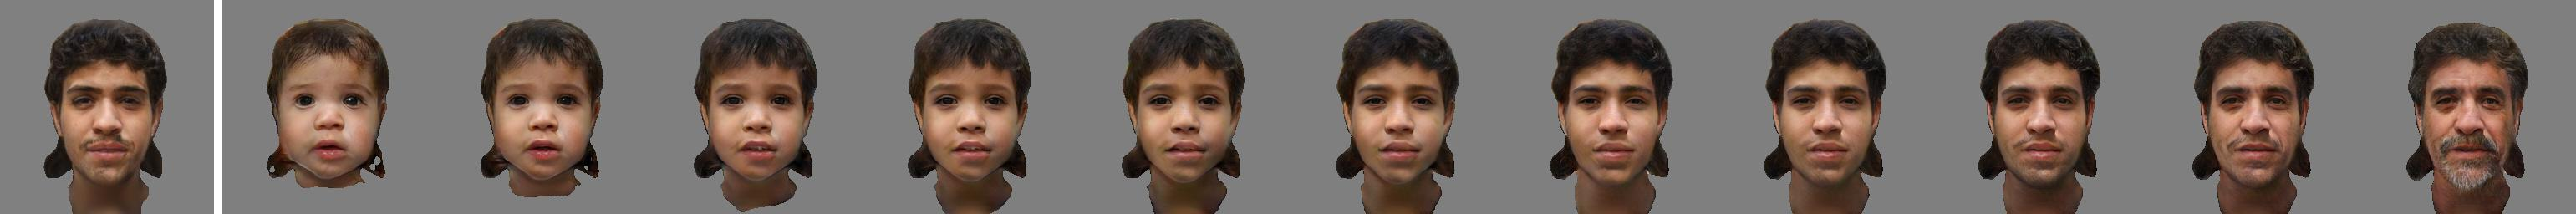

In [25]:
display.Image("results/ocessedimg.jpg")

### 4.

In [26]:
path = "../atfalmafkoda_unzip/test_images/324892124_2155098354688223_8329344201853262393_n_3175915139372758.jpg"
inference(path, opt, 'male', enhance=True, align=False)

created temporary directory /scratch/6872595.1.csgpu/tmp5fx9d20m
AgingDataLoader
dataset [MulticlassUnalignedDataset] was created
Generator(
  (id_encoder): IdentityEncoder(
    (encoder): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): EqualConv2d(
        (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
      )
      (2): PixelNorm()
      (3): ReLU(inplace=True)
      (4): ReflectionPad2d((1, 1, 1, 1))
      (5): EqualConv2d(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
      )
      (6): PixelNorm()
      (7): ReLU(inplace=True)
      (8): ReflectionPad2d((1, 1, 1, 1))
      (9): EqualConv2d(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
      )
      (10): PixelNorm()
      (11): ReLU(inplace=True)
      (12): ResnetBlock(
        (conv_block): Sequential(
          (0): ReflectionPad2d((1, 1, 1, 1))
          (1): EqualConv2d(
            (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
          )
   

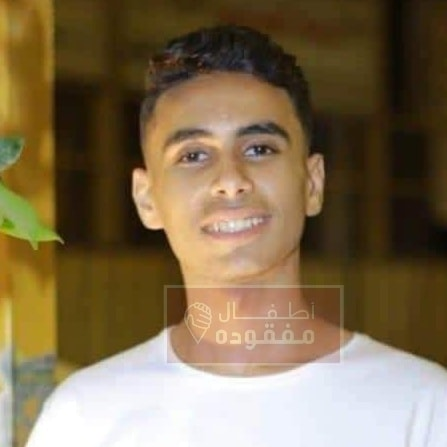

In [27]:
display.Image("../atfalmafkoda_unzip/test_images/324892124_2155098354688223_8329344201853262393_n_3175915139372758.jpg", width=300, height=300)

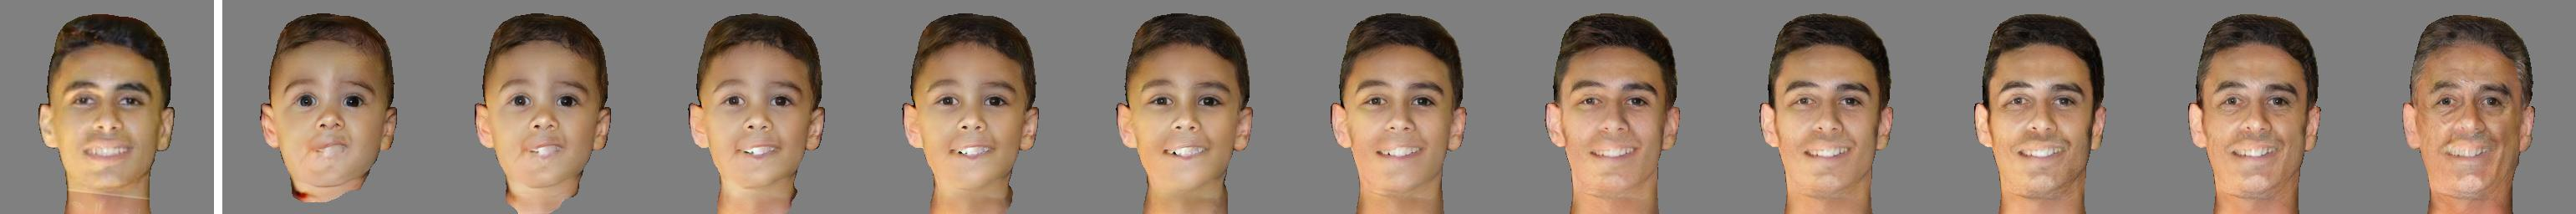

In [28]:
display.Image("results/ocessedimg.jpg")

### 5.

In [30]:
path = "../atfalmafkoda_unzip/test_images/12829092_1549979721966316_1175738599317244195_o_1549979721966316.jpg"
inference(path, opt, 'male', enhance=True, align=False)

created temporary directory /scratch/6872595.1.csgpu/tmptcad042r
AgingDataLoader
dataset [MulticlassUnalignedDataset] was created
Generator(
  (id_encoder): IdentityEncoder(
    (encoder): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): EqualConv2d(
        (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
      )
      (2): PixelNorm()
      (3): ReLU(inplace=True)
      (4): ReflectionPad2d((1, 1, 1, 1))
      (5): EqualConv2d(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
      )
      (6): PixelNorm()
      (7): ReLU(inplace=True)
      (8): ReflectionPad2d((1, 1, 1, 1))
      (9): EqualConv2d(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
      )
      (10): PixelNorm()
      (11): ReLU(inplace=True)
      (12): ResnetBlock(
        (conv_block): Sequential(
          (0): ReflectionPad2d((1, 1, 1, 1))
          (1): EqualConv2d(
            (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
          )
   

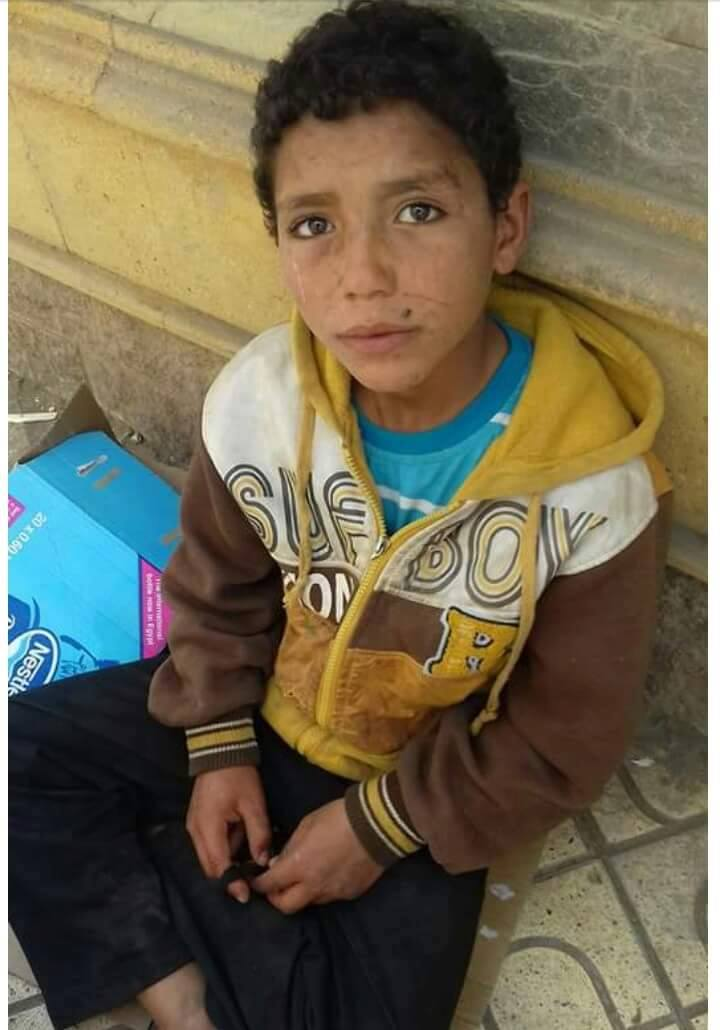

In [31]:
display.Image(path, width=300, height=300)

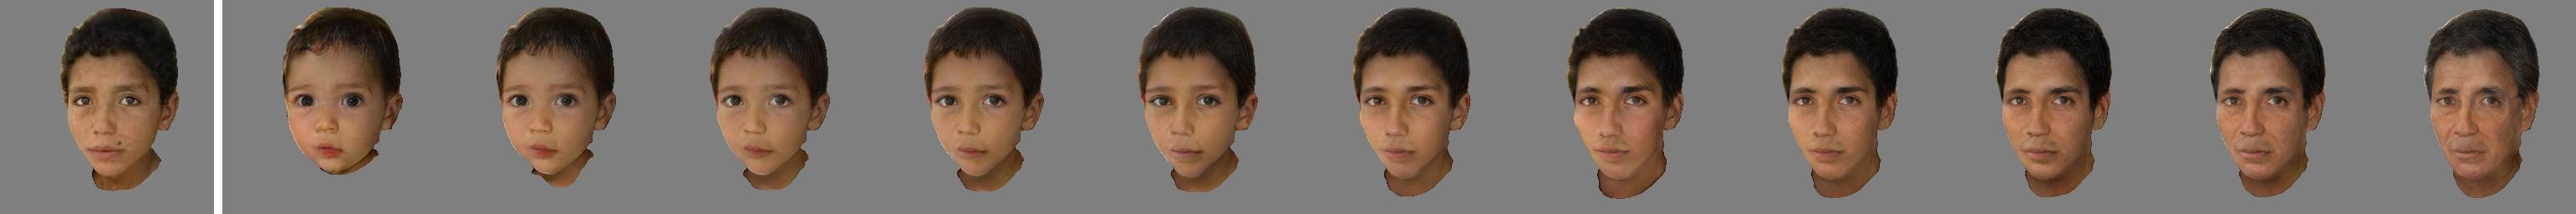

In [32]:
display.Image("results/ocessedimg.jpg")

### 6.

In [33]:
path = "../atfalmafkoda_unzip/test_images/131646769_2622248061406138_762045808063640660_n_2622248058072805.jpg"
inference(path, opt, 'male', enhance=True, align=False)

created temporary directory /scratch/6872595.1.csgpu/tmpa3d7c18j
AgingDataLoader
dataset [MulticlassUnalignedDataset] was created
Generator(
  (id_encoder): IdentityEncoder(
    (encoder): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): EqualConv2d(
        (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
      )
      (2): PixelNorm()
      (3): ReLU(inplace=True)
      (4): ReflectionPad2d((1, 1, 1, 1))
      (5): EqualConv2d(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
      )
      (6): PixelNorm()
      (7): ReLU(inplace=True)
      (8): ReflectionPad2d((1, 1, 1, 1))
      (9): EqualConv2d(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
      )
      (10): PixelNorm()
      (11): ReLU(inplace=True)
      (12): ResnetBlock(
        (conv_block): Sequential(
          (0): ReflectionPad2d((1, 1, 1, 1))
          (1): EqualConv2d(
            (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
          )
   

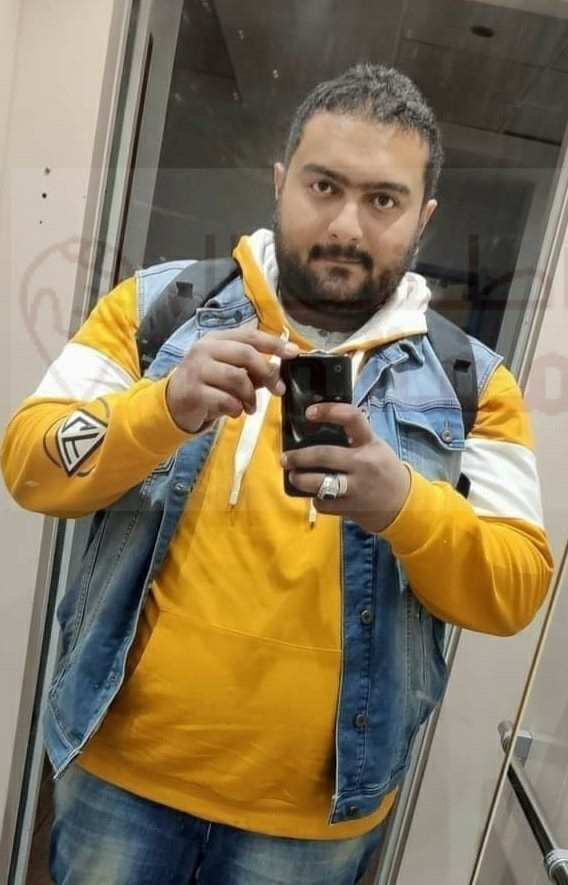

In [34]:
display.Image(path, width=300, height=300)

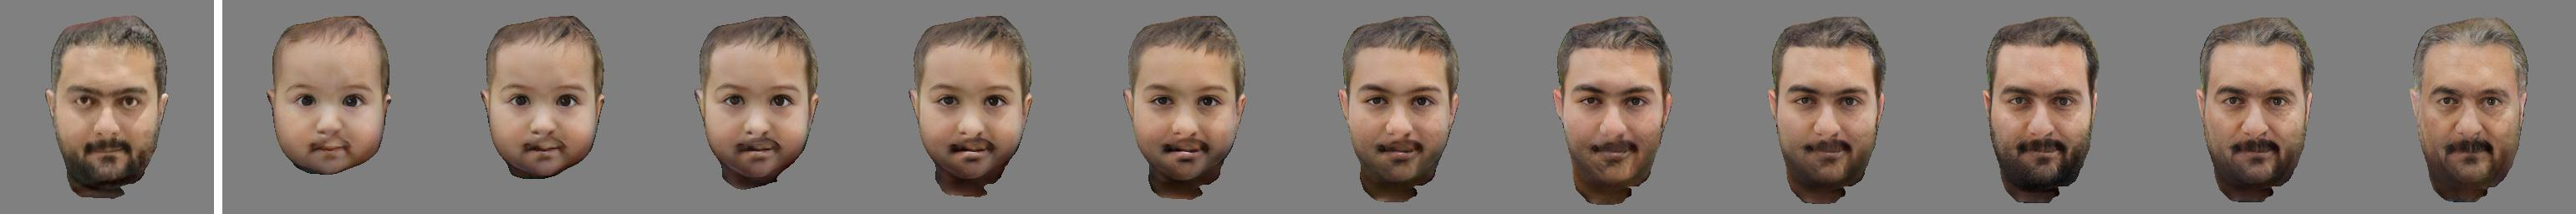

In [35]:
display.Image("results/ocessedimg.jpg")

### 6.

In [46]:
path = "../atfalmafkoda_unzip/test_images/13510972_1593495877614700_2530072853449477142_n_1593495877614700.jpg"
inference(path, opt, 'male', enhance=True, align=True)

created temporary directory /scratch/6872595.1.csgpu/tmpoz_sldbc
Aligned image has shape: (256, 256)
Inference took 0.0347 seconds.
AgingDataLoader
dataset [MulticlassUnalignedDataset] was created
Generator(
  (id_encoder): IdentityEncoder(
    (encoder): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): EqualConv2d(
        (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
      )
      (2): PixelNorm()
      (3): ReLU(inplace=True)
      (4): ReflectionPad2d((1, 1, 1, 1))
      (5): EqualConv2d(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
      )
      (6): PixelNorm()
      (7): ReLU(inplace=True)
      (8): ReflectionPad2d((1, 1, 1, 1))
      (9): EqualConv2d(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
      )
      (10): PixelNorm()
      (11): ReLU(inplace=True)
      (12): ResnetBlock(
        (conv_block): Sequential(
          (0): ReflectionPad2d((1, 1, 1, 1))
          (1): EqualConv2d(
            (conv): 

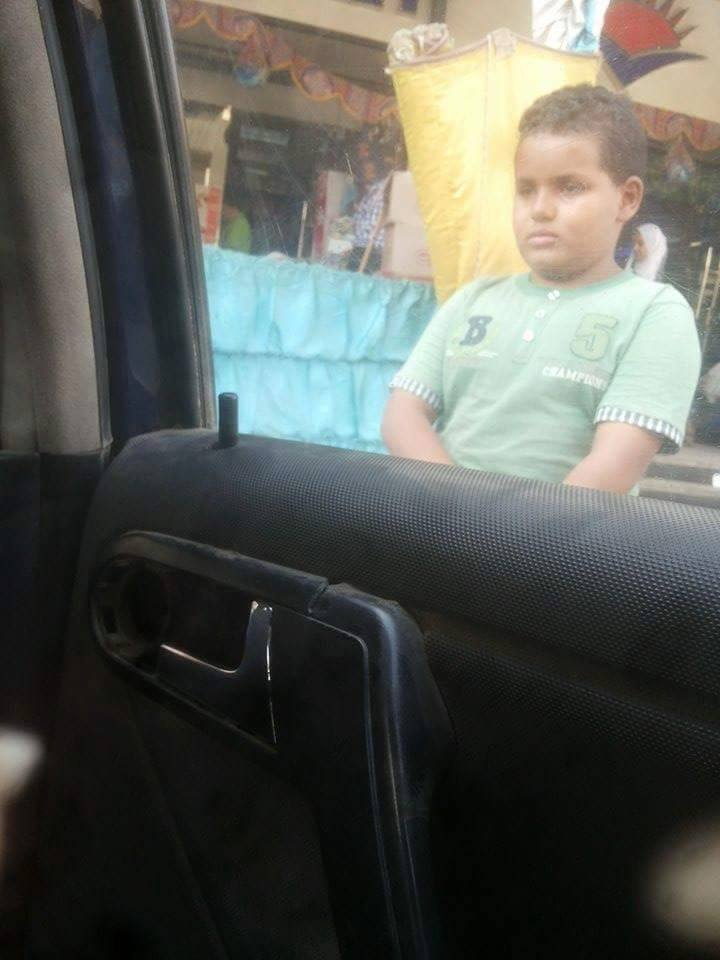

In [47]:
display.Image(path, width=300, height=300)

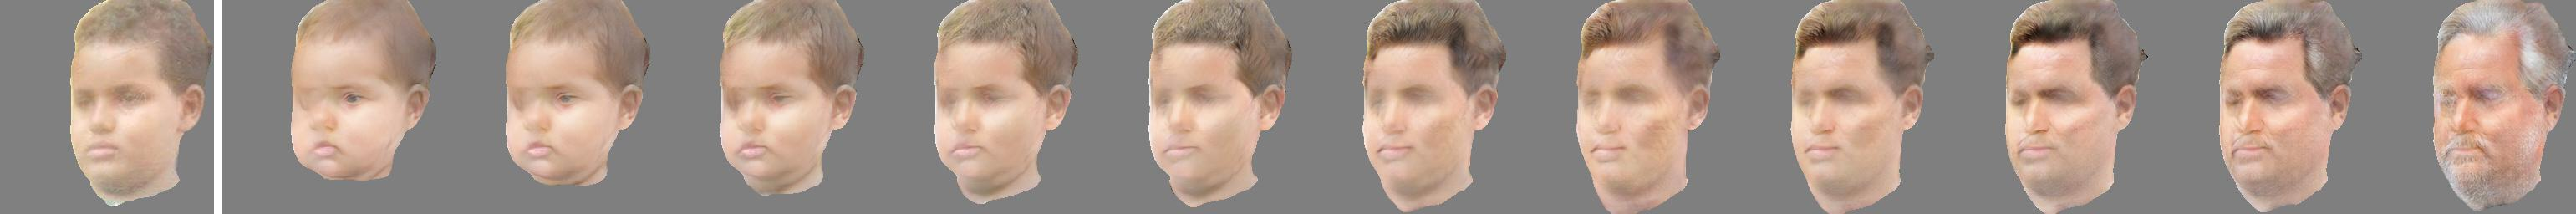

In [48]:
display.Image("results/ocessedimg.jpg")

### 7.

In [49]:
path = "../atfalmafkoda_unzip/test_images/137269446_2637019409929003_89181894202104145_n_2637019399929004.jpg"
inference(path, opt, 'female', enhance=False, align=True)

created temporary directory /scratch/6872595.1.csgpu/tmp2u28_xac
Aligned image has shape: (256, 256)
Inference took 0.0350 seconds.
AgingDataLoader
dataset [MulticlassUnalignedDataset] was created
Generator(
  (id_encoder): IdentityEncoder(
    (encoder): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): EqualConv2d(
        (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
      )
      (2): PixelNorm()
      (3): ReLU(inplace=True)
      (4): ReflectionPad2d((1, 1, 1, 1))
      (5): EqualConv2d(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
      )
      (6): PixelNorm()
      (7): ReLU(inplace=True)
      (8): ReflectionPad2d((1, 1, 1, 1))
      (9): EqualConv2d(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
      )
      (10): PixelNorm()
      (11): ReLU(inplace=True)
      (12): ResnetBlock(
        (conv_block): Sequential(
          (0): ReflectionPad2d((1, 1, 1, 1))
          (1): EqualConv2d(
            (conv): 

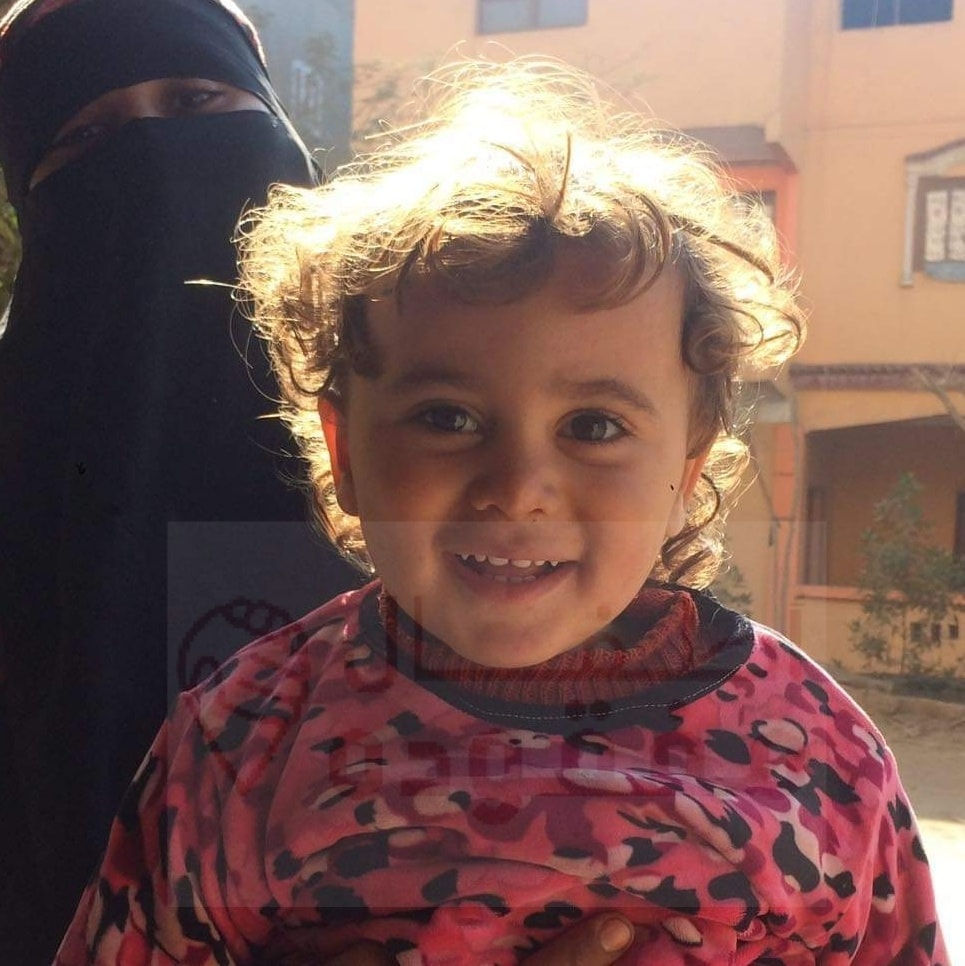

In [50]:
display.Image(path, width=300, height=300)

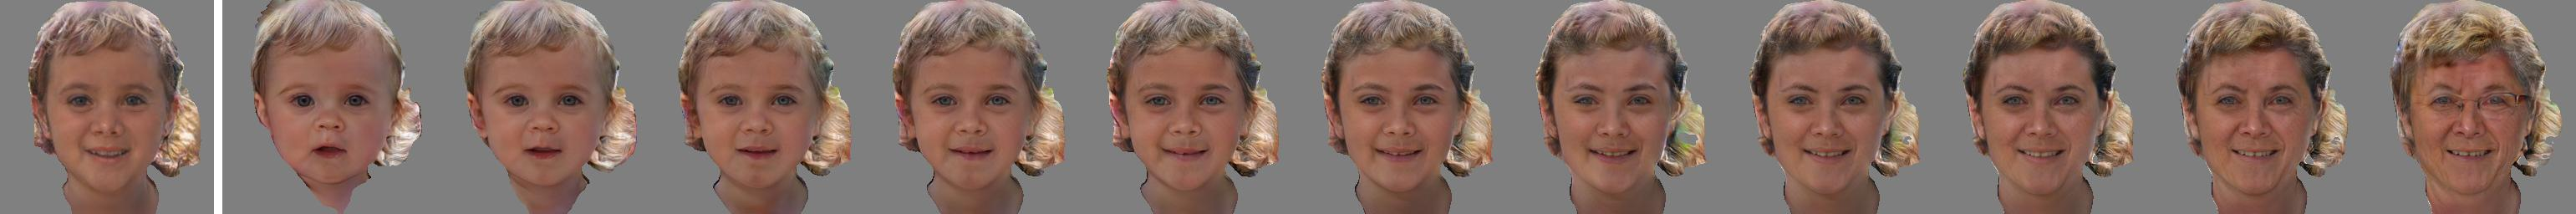

In [51]:
display.Image("results/ocessedimg.jpg")

### 7.

In [64]:
path = "../atfalmafkoda_unzip/test_images/50639501_2062509287380021_219617719547330560_n_2062509280713355.jpg"
inference(path, opt, 'male', enhance=True, align=True)

created temporary directory /scratch/6872595.1.csgpu/tmpfjljkpn5
Aligned image has shape: (256, 256)
Inference took 0.0354 seconds.
AgingDataLoader
dataset [MulticlassUnalignedDataset] was created
Generator(
  (id_encoder): IdentityEncoder(
    (encoder): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): EqualConv2d(
        (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
      )
      (2): PixelNorm()
      (3): ReLU(inplace=True)
      (4): ReflectionPad2d((1, 1, 1, 1))
      (5): EqualConv2d(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
      )
      (6): PixelNorm()
      (7): ReLU(inplace=True)
      (8): ReflectionPad2d((1, 1, 1, 1))
      (9): EqualConv2d(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
      )
      (10): PixelNorm()
      (11): ReLU(inplace=True)
      (12): ResnetBlock(
        (conv_block): Sequential(
          (0): ReflectionPad2d((1, 1, 1, 1))
          (1): EqualConv2d(
            (conv): 

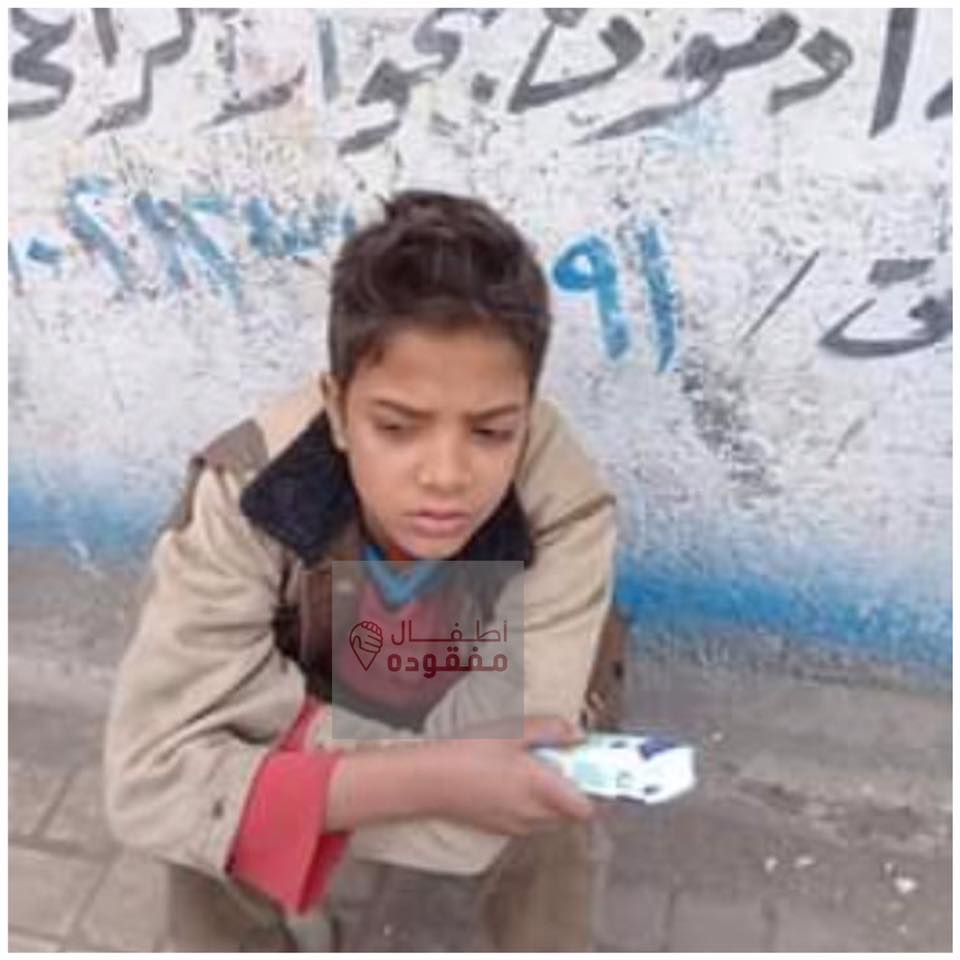

In [65]:
display.Image(path, width=300, height=300)

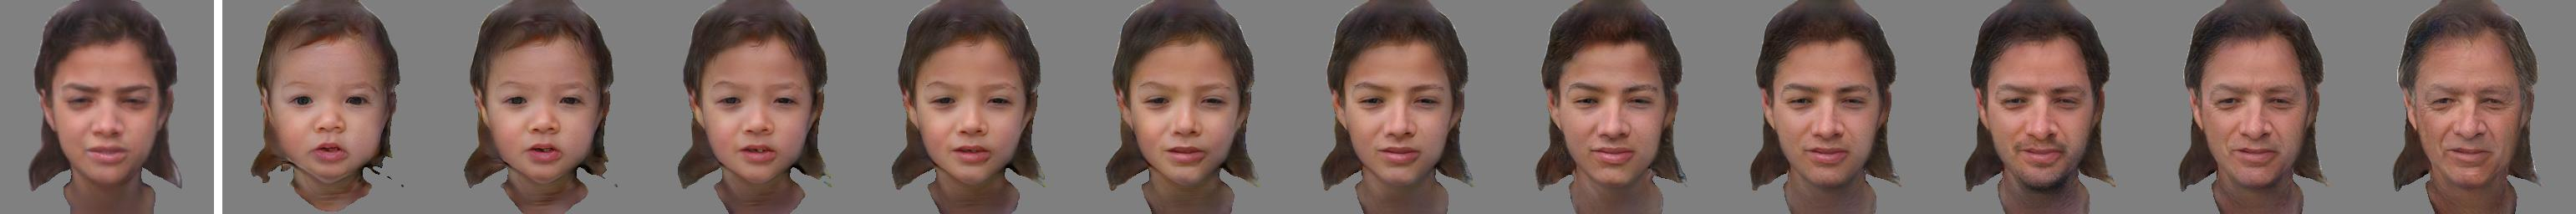

In [66]:
display.Image("results/ocessedimg.jpg")

In [29]:
good = ["../atfalmafkoda_unzip/test_images/121166892_2565644000399878_845050290048897700_n_2565643997066545.jpg",
       "../atfalmafkoda_unzip/test_images/121374409_2565231617107783_7695266934953700188_n_2565231610441117.jpg",
        "../atfalmafkoda_unzip/test_images/12829092_1549979721966316_1175738599317244195_o_1549979721966316.jpg",
        "../atfalmafkoda_unzip/test_images/17015760_1699343057029981_6123416485212248384_o_1699343057029981.jpg",
        
       
       
       
       ]